In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
%matplotlib inline

class Bandit:
    def __init__(self, k_arm=10, true_reward=0.0):
        self.k = k_arm
        self.true_reward = true_reward
        self.actions_values = None
        self.best_action = None

    def reset(self):    # reset the bandit with new true action values
        self.actions_values = np.random.randn(self.k) + self.true_reward
        self.best_action = np.argmax(self.actions_values)

    def pull(self, action: int) -> float:    # pull an arm, return stochastic reward
        return np.random.randn() + self.actions_values[action]

class Agent:
    def __init__(self, k_arm=10, epsilon=0.0, sample_averages=True,
                 q_init=0.0, step_size=None):   # added q_init + step_size
        self.k = k_arm
        self.epsilon = epsilon
        self.sample_averages = sample_averages
        self.q_init = q_init                    # store optimistic initialization value
        self.step_size = step_size              # allow constant step-size
        self.q_estimation = None
        self.action_count = None
        self.available_actions = np.arange(self.k)

    def reset(self):
        self.q_estimation = np.full(self.k, self.q_init, dtype=float)
        self.action_count = np.zeros(self.k, dtype=float)

    def act(self) -> int:   # choose action using epsilon-greedy
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.available_actions)
        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])

    def learn(self, action: int, reward: float):
        self.action_count[action] += 1
        # choose alpha dynamically
        if self.sample_averages and self.step_size is None:
            alpha = 1.0 / self.action_count[action]
        else:
            alpha = self.step_size if self.step_size is not None else 0.0
        # apply update rule
        if alpha > 0.0:
            self.q_estimation[action] += alpha * (reward - self.q_estimation[action])

class UCB:
    def __init__(self, k_arm=10, c=2.0, step_size=None):
        self.k = k_arm
        self.c = c
        self.step_size = step_size
        self.q_estimation = None
        self.action_count = None
        self.t = 0

    def reset(self):
        self.q_estimation = np.zeros(self.k, dtype=float)
        self.action_count = np.zeros(self.k, dtype=float)
        self.t = 0

    def act(self) -> int:
        self.t += 1
        untried = np.where(self.action_count == 0)[0]
        if len(untried) > 0:
            return np.random.choice(untried)
        bonus = self.c * np.sqrt(np.log(self.t) / self.action_count)
        ucb = self.q_estimation + bonus
        u = np.max(ucb)
        return np.random.choice(np.where(ucb == u)[0])

    def learn(self, action: int, reward: float):
        self.action_count[action] += 1
        alpha = 1.0 / self.action_count[action] if self.step_size is None else self.step_size
        self.q_estimation[action] += alpha * (reward - self.q_estimation[action])

def simulate(runs, time, agents, envs):
    rewards = np.zeros((len(agents), runs, time))   # reward log
    best_action_counts = np.zeros_like(rewards)     # optimal action log

    for i, (agent, env) in enumerate(zip(agents, envs)):
        for r in range(runs):
            env.reset(); agent.reset()
            for t in range(time):
                action = agent.act()            # pick action
                reward = env.pull(action)       # get reward
                agent.learn(action, reward)     # update estimate
                rewards[i, r, t] = reward       # record reward
                best_action_counts[i, r, t] = (action == env.best_action)

    return best_action_counts.mean(axis=1), rewards.mean(axis=1) # averages

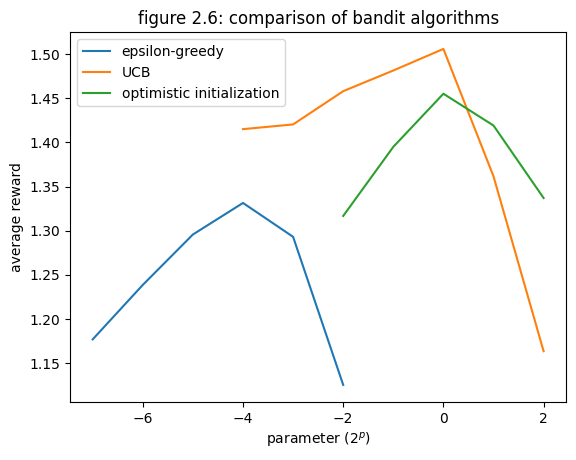

In [2]:
def build_eps_greedy(p):
    eps = 2.0 ** p
    return Agent(k_arm=10, epsilon=eps, sample_averages=True)

def build_ucb(p):
    c = 2.0 ** p
    return UCB(k_arm=10, c=c, step_size=None)

def build_opt_init(p):
    q0 = 2.0 ** p
    return Agent(k_arm=10, epsilon=0.0, sample_averages=False, q_init=q0, step_size=0.1)

agents = []
builders = [build_eps_greedy, build_ucb, build_opt_init]
param_grids = [
    np.arange(-7, -1, dtype=float),
    np.arange(-4, 3, dtype=float),
    np.arange(-2, 3, dtype=float)
]

for grid, builder in zip(param_grids, builders):
    for p in grid:
        agents.append(builder(p))

envs = [Bandit(k_arm=10, true_reward=0.0) for _ in agents]
best_action_rates, avg_rewards = simulate(runs=2000, time=1000, agents=agents, envs=envs)

rewards_per_agent = avg_rewards.mean(axis=1)

labels = ['epsilon-greedy', 'UCB', 'optimistic initialization']
idx = 0
for label, grid in zip(labels, param_grids):
    n = len(grid)
    plt.plot(grid, rewards_per_agent[idx:idx+n], label=label)
    idx += n

plt.xlabel('parameter ($2^p$)')
plt.ylabel('average reward')
plt.title('figure 2.6: comparison of bandit algorithms')
plt.legend()
plt.show()